## Importing the Essential Libraries

In [1]:
import os
import cv2
import math
import keras
import skimage
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models,layers
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
import preprocessing
import segmentation
import classification

In [3]:
EPOCHS=30
CHANNELS=3
BATCH_SIZE=32
IMAGE_SIZE=256
input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

## Visualizing the dataset with diseases Size

In [4]:
def Dataset_Plot(path, ax, title):
    root_path = path
    files = os.listdir(root_path)

    image_count = {}
    for file in files:
        images = os.listdir(root_path + file + os.sep)
        count = len(images)
        image_count[file] = count

    ax.bar(image_count.keys(), image_count.values())
    ax.set_xticklabels(image_count.keys(), rotation=90)
    ax.set_xlabel('Files')
    ax.set_ylabel('Number of Images')
    ax.set_title(title)

    for index, value in enumerate(image_count.values()):
        ax.text(index, value + 0.5, str(value), ha='center')

C:\Users\Krishna\AppData\Local\Temp\ipykernel_4656\1582116718.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(image_count.keys(), rotation=90)


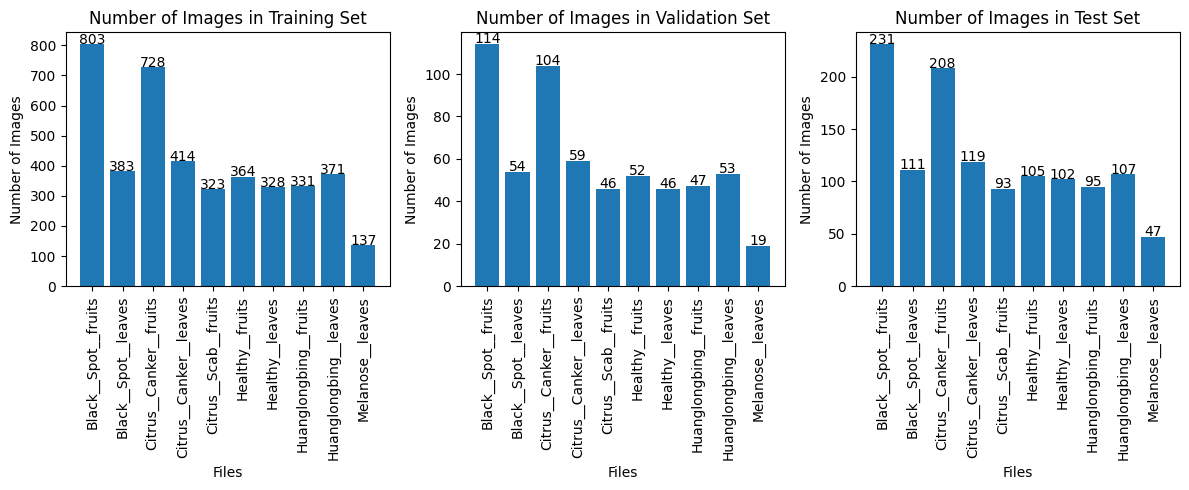

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

train_path = "../Orange/datasets/train/"
val_path = "../Orange/datasets/val/"
test_path = "../Orange/datasets/test/"

Dataset_Plot(train_path, ax1, 'Number of Images in Training Set')
Dataset_Plot(val_path, ax2, 'Number of Images in Validation Set')
Dataset_Plot(test_path, ax3, 'Number of Images in Test Set')

plt.tight_layout()
plt.show()

## Started Working with only Orange Fruit Images

In [6]:
fruit_class_name=["Black__Spot__fruits","Citrus__Canker__fruits","Citrus__Scab__fruits","Healthy__fruits","Huanglongbing__fruits"]

### Pre-process Image

In [7]:
path="../Orange/datasets/train/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
f_train_generator=obj1.PreprocessImage(fruit_class_name)
f_train_generator

Found 2549 images belonging to 5 classes.


In [8]:
path="../Orange/datasets/val/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
f_val_generator=obj1.PreprocessImage(fruit_class_name)
f_val_generator

Found 363 images belonging to 5 classes.


In [9]:
path="../Orange/datasets/test/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
f_test_generator=obj1.PreprocessImage(fruit_class_name)
f_test_generator

Found 732 images belonging to 5 classes.


### Segmentate Image

In [4]:
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, generator):
    self.generator = generator

  def __len__(self):
    return len(self.generator)

  def __getitem__(self, idx):
    x_batch, y_batch = self.generator[idx]
    x_augmented = []
    for i in range(len(x_batch)):
      image = (x_batch[i] * 255).round().astype(np.uint8)
      obj2 = segmentation.IMAGE_SEGMENTATION(image)
      mask = obj2.AnalyzeImage()
      image = obj2.Segmentation(mask)
      x_augmented.append(image)
    return np.array(x_augmented), np.array(y_batch)


In [11]:
segf_train_generator = DataGenerator(f_train_generator)
segf_val_generator = DataGenerator(f_val_generator)
segf_test_generator = DataGenerator(f_test_generator)

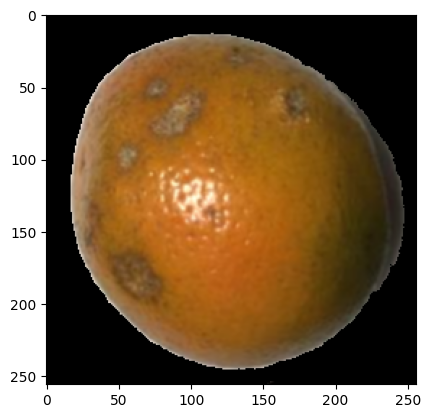

In [13]:
for img,lbl in segf_train_generator:
    plt.imshow(img[30])
    break

### Classification of image

In [14]:
obj3=classification.CNN()
f_model=obj3.Classification(input_shape=input_shape,n_classes=len(fruit_class_name))

f_model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [15]:
steps_per_epochs=len(segf_train_generator)
validation_steps=len(segf_val_generator)
print(steps_per_epochs,validation_steps)

80 12


In [16]:
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


In [17]:
history = f_model.fit(segf_train_generator, steps_per_epoch=steps_per_epochs, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1, validation_data=segf_val_generator, validation_steps=validation_steps,
                      callbacks=[early_stop])

Epoch 1/30
80/80 [==============================] - 136s 2s/step - loss: 1.5021 - accuracy: 0.5865 - val_loss: 0.5198 - val_accuracy: 0.8154
Epoch 2/30
80/80 [==============================] - 148s 2s/step - loss: 0.4767 - accuracy: 0.8086 - val_loss: 0.3772 - val_accuracy: 0.8705
Epoch 3/30
80/80 [==============================] - 171s 2s/step - loss: 0.3074 - accuracy: 0.8968 - val_loss: 0.4244 - val_accuracy: 0.8567
Epoch 4/30
80/80 [==============================] - 154s 2s/step - loss: 0.3021 - accuracy: 0.8925 - val_loss: 0.3445 - val_accuracy: 0.8871
Epoch 5/30
80/80 [==============================] - 152s 2s/step - loss: 0.2364 - accuracy: 0.9168 - val_loss: 0.2560 - val_accuracy: 0.9256
Epoch 6/30
80/80 [==============================] - 159s 2s/step - loss: 0.1796 - accuracy: 0.9384 - val_loss: 0.2200 - val_accuracy: 0.9421
Epoch 7/30
80/80 [==============================] - 158s 2s/step - loss: 0.1323 - accuracy: 0.9553 - val_loss: 0.3707 - val_accuracy: 0.8926
Epoch 8/30
80

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [19]:
EPOCHS=25

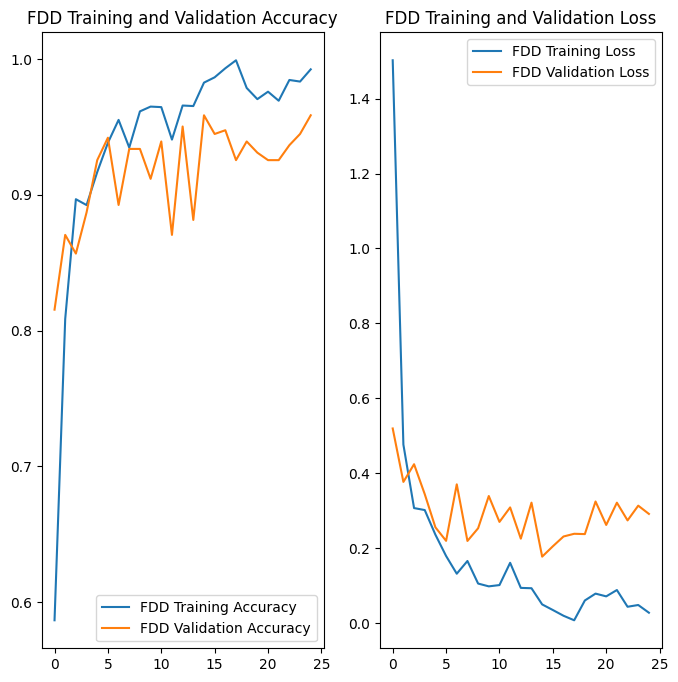

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='FDD Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='FDD Validation Accuracy')
plt.legend(loc='lower right')
plt.title('FDD Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='FDD Training Loss')
plt.plot(range(EPOCHS),val_loss,label='FDD Validation Loss')
plt.legend(loc='upper right')
plt.title('FDD Training and Validation Loss')
plt.show()

In [21]:
f_pr=f_model.evaluate(segf_test_generator)

23/23 [==============================] - 27s 1s/step - loss: 0.0816 - accuracy: 0.9809


In [4]:
def predict(model,img):

    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0) #create a batch

    predictions=model.predict(img_array)

    predicted_class=fruit_class_name[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 51ms/step


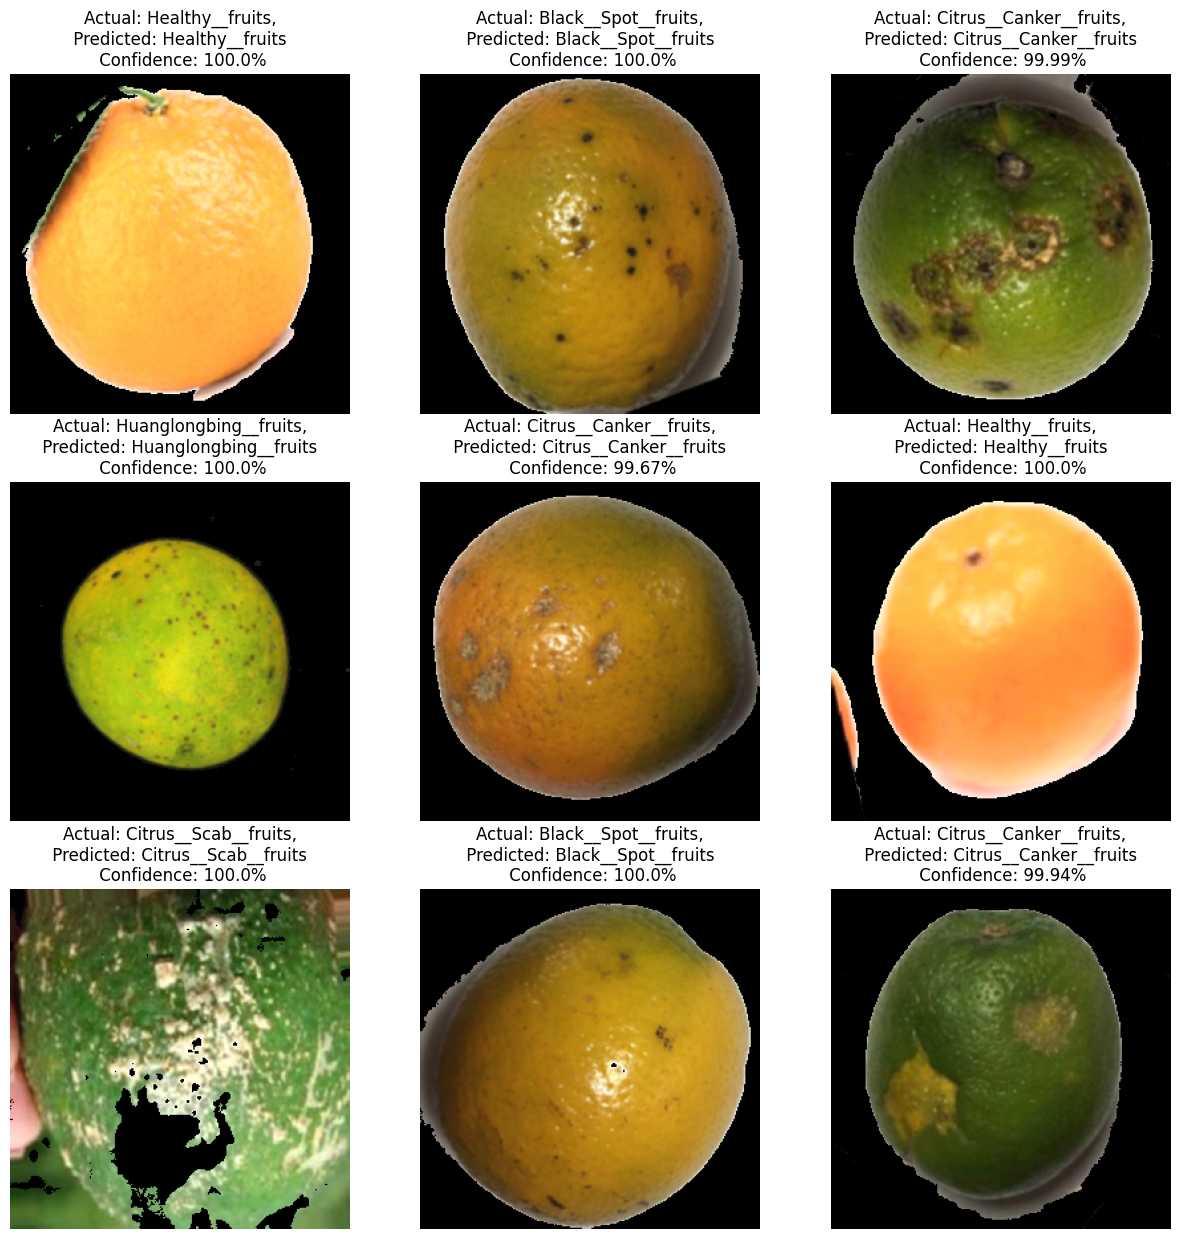

In [48]:
plt.figure(figsize=(15,15))

for images,labels in segf_test_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        predicted_class,confidence=predict(f_model,images[i])
        actual_class=fruit_class_name[labels[i].astype("int")]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")
    break

In [24]:
predictions=f_model.predict_generator(segf_test_generator,steps=len(segf_test_generator))
predicted_classes=np.array(np.argmax(predictions,axis=1))

C:\Users\Krishna\AppData\Local\Temp\ipykernel_15816\3773274097.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=f_model.predict_generator(segf_test_generator,steps=len(segf_test_generator))


In [38]:
labels = []
for batch in segf_test_generator:
    labels.append(batch[1])
labels = np.concatenate(labels)

In [44]:
cm=confusion_matrix(labels,predicted_classes)

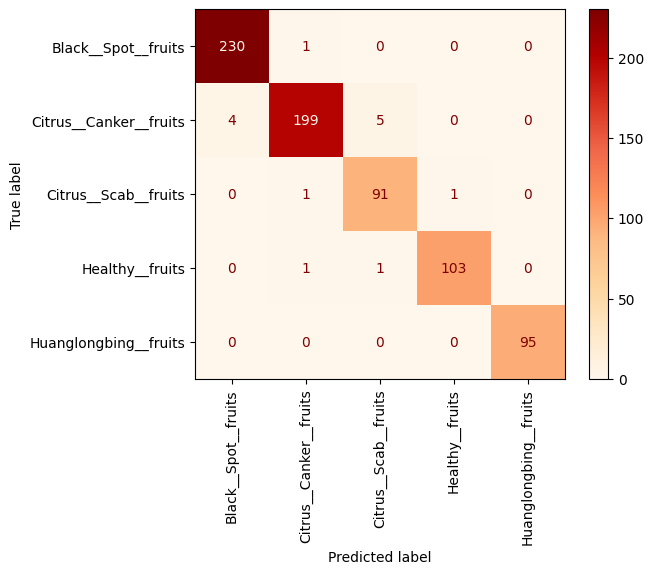

In [45]:
display_cm=ConfusionMatrixDisplay(cm,display_labels=fruit_class_name)
display_cm.plot(cmap='OrRd',xticks_rotation=90)
plt.show()

In [46]:
f_model.save("../Models/f_model.h5")

### Testing on Image

In [8]:
load_model=keras.models.load_model('../Models/f_model.h5')

img=cv2.imread('../Orange/datasets/test/Citrus__Canker__fruits/ccf (1009).jpg')
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

obj1=preprocessing.IMAGE_PREPROCESSING(img_rgb)
gen=obj1.PreprocessImage(fruit_class_name)

image = (gen[0][0] * 255).round().astype(np.uint8)
obj2 = segmentation.IMAGE_SEGMENTATION(image)
mask = obj2.AnalyzeImage()
image = obj2.Segmentation(mask)

arr=[image]
array=np.array(arr)
pred=load_model.predict(array)
pred_class=fruit_class_name[np.argmax(pred)]
print(pred_class)

obj3=classification.CNN()
solution=obj3.Solution(pred_class)
print(solution)

1/1 [==============================] - 0s 120ms/step
Citrus__Canker__fruits



 a. If the disease is introduced in area, all infected trees should be removed and destroyed. 
 b. In areas where disease is endemic, windbreaks can help to reduce severity. 
 c. Cultural control of disease should focus on controlling leaf miner populations, utilizing wind breaks and application of copper spray.


### Wrongly identified Images

In [36]:
import os

wrongly_classified_images = []

# Assuming the leaf and fruit disease images are stored in a folder
folder_path = "../Orange/datasets/test/"

# Assuming you have a trained CNN model
model = keras.models.load_model('../Models/f_model.h5')  # Your trained CNN model

# Define a list of leaf disease class names
fruit_disease_classes = fruit_class_name

# Iterate over the leaf disease class names
for class_name in fruit_disease_classes:
    class_folder_path = os.path.join(folder_path, class_name)

    # Skip if the leaf disease class folder doesn't exist
    if not os.path.isdir(class_folder_path):
        continue

    # Iterate over the files in the leaf disease class folder
    for filename in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, filename)

        img=cv2.imread(image_path)
        img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        obj1=preprocessing.IMAGE_PREPROCESSING(img_rgb)
        gen=obj1.PreprocessImage(fruit_class_name)
        # # Load and preprocess the image (this step may vary depending on your implementation)
        # image = load_image(image_path)
        # preprocessed_image = preprocess_image(image)
        image = (gen[0][0] * 255).round().astype(np.uint8)
        obj2 = segmentation.IMAGE_SEGMENTATION(image)
        mask = obj2.AnalyzeImage()
        image = obj2.Segmentation(mask)
        # # Make predictions using the CNN model
        # predictions = model.predict(preprocessed_image)
        arr=[image]
        array=np.array(arr)
        pred=model.predict(array)
        pred_class=fruit_class_name[np.argmax(pred)]
        # # Get the predicted class
        # predicted_class = np.argmax(predictions)
        true_label = fruit_class_name[fruit_disease_classes.index(class_name)]
        # Compare the predicted class with the true label
        if pred_class != true_label:
            wrongly_classified_images.append((filename, true_label, pred_class))


# Print the list of wrongly classified image paths
print("Wrongly classified images:")
for image_details in wrongly_classified_images:
    image_name, true_label, predicted_class = image_details
    print(f"Image: {image_name}, Actual Class: {true_label}, Predicted Class: {predicted_class}")


1/1 [==============================] - 0s 32ms/step
Wrongly classified images:
Image: bsf (279).jpg, Actual Class: Black__Spot__fruits, Predicted Class: Citrus__Canker__fruits
Image: ccf (134).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Citrus__Scab__fruits
Image: ccf (171).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Citrus__Scab__fruits
Image: ccf (27).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Citrus__Scab__fruits
Image: ccf (3).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Citrus__Scab__fruits
Image: ccf (7).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Citrus__Scab__fruits
Image: ccf (724).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Black__Spot__fruits
Image: ccf (725).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Black__Spot__fruits
Image: ccf (943).jpg, Actual Class: Citrus__Canker__fruits, Predicted Class: Black__Spot__fruits
Image: ccf (945).jpg, Actual Class: Citrus__Cank

## Started Working with only Orange Leaf Images

In [9]:
leaf_class_name=["Black__Spot__leaves","Citrus__Canker__leaves","Healthy__leaves","Huanglongbing__leaves","Melanose__leaves"]

### Pre-process Image

In [4]:
path="../Orange/datasets/train/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
l_train_generator=obj1.PreprocessImage(leaf_class_name)
l_train_generator

Found 1633 images belonging to 5 classes.


In [5]:
path="../Orange/datasets/val/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
l_val_generator=obj1.PreprocessImage(leaf_class_name)
l_val_generator

Found 231 images belonging to 5 classes.


In [6]:
path="../Orange/datasets/test/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
l_test_generator=obj1.PreprocessImage(leaf_class_name)
l_test_generator

Found 486 images belonging to 5 classes.


### Segmentate Image

In [5]:
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, generator):
    self.generator = generator

  def __len__(self):
    return len(self.generator)

  def __getitem__(self, idx):
    x_batch, y_batch = self.generator[idx]
    x_augmented = []
    for i in range(len(x_batch)):
      image = (x_batch[i] * 255).round().astype(np.uint8)
      obj2 = segmentation.IMAGE_SEGMENTATION(image)
      mask = obj2.AnalyzeImage()
      image = obj2.Segmentation(mask)
      x_augmented.append(image)
    return np.array(x_augmented), np.array(y_batch)

In [8]:
segl_train_generator = DataGenerator(l_train_generator)
segl_val_generator = DataGenerator(l_val_generator)
segl_test_generator = DataGenerator(l_test_generator)

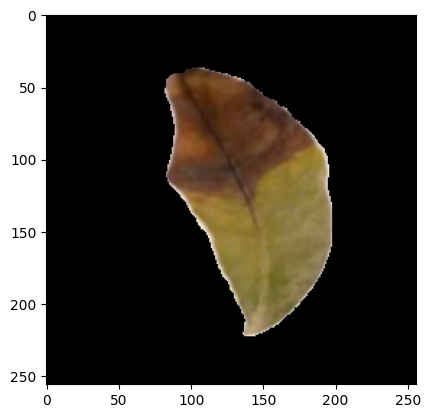

In [9]:
for img,lbl in segl_train_generator:
    plt.imshow(img[0])
    break

### Classification of Image

In [12]:
obj3=classification.CNN()
l_model=obj3.Classification(input_shape=input_shape,n_classes=len(leaf_class_name))

l_model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [13]:
steps_per_epochs=len(segl_train_generator)
validation_steps=len(segl_val_generator)
print(steps_per_epochs,validation_steps)

52 8


In [14]:
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [15]:
history = l_model.fit(segl_train_generator, steps_per_epoch=steps_per_epochs, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1, validation_data=segl_val_generator, validation_steps=validation_steps,
                      callbacks=[early_stop])

Epoch 1/30
52/52 [==============================] - 124s 2s/step - loss: 1.8242 - accuracy: 0.4170 - val_loss: 1.0385 - val_accuracy: 0.5844
Epoch 2/30
52/52 [==============================] - 120s 2s/step - loss: 0.8242 - accuracy: 0.6840 - val_loss: 0.6184 - val_accuracy: 0.7835
Epoch 3/30
52/52 [==============================] - 121s 2s/step - loss: 0.6016 - accuracy: 0.7697 - val_loss: 0.5700 - val_accuracy: 0.8009
Epoch 4/30
52/52 [==============================] - 124s 2s/step - loss: 0.5038 - accuracy: 0.8102 - val_loss: 0.3976 - val_accuracy: 0.8398
Epoch 5/30
52/52 [==============================] - 123s 2s/step - loss: 0.4004 - accuracy: 0.8512 - val_loss: 0.4437 - val_accuracy: 0.8139
Epoch 6/30
52/52 [==============================] - 120s 2s/step - loss: 0.4138 - accuracy: 0.8567 - val_loss: 0.7796 - val_accuracy: 0.7662
Epoch 7/30
52/52 [==============================] - 118s 2s/step - loss: 0.3828 - accuracy: 0.8683 - val_loss: 0.5290 - val_accuracy: 0.8095
Epoch 8/30
52

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [17]:
EPOCHS=29

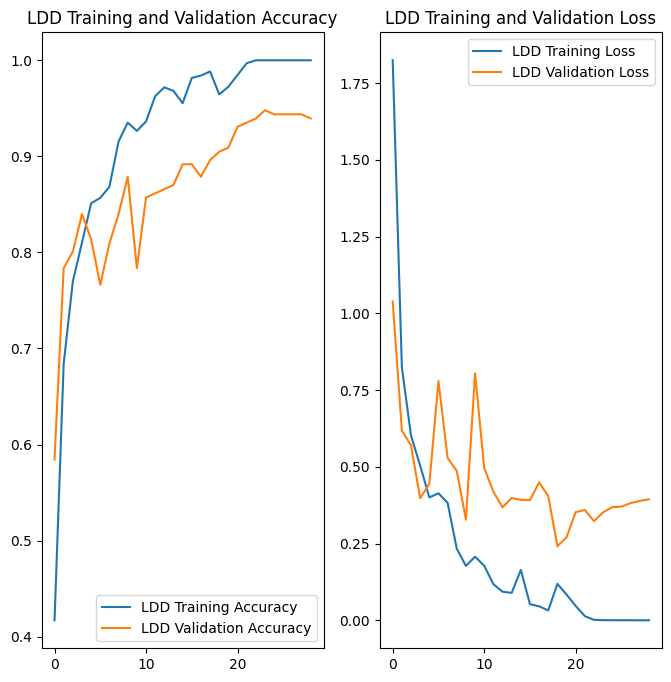

In [18]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='LDD Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='LDD Validation Accuracy')
plt.legend(loc='lower right')
plt.title('LDD Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='LDD Training Loss')
plt.plot(range(EPOCHS),val_loss,label='LDD Validation Loss')
plt.legend(loc='upper right')
plt.title('LDD Training and Validation Loss')
plt.show()

In [19]:
l_pr=l_model.evaluate(segl_test_generator)

16/16 [==============================] - 17s 1s/step - loss: 0.3296 - accuracy: 0.9053


In [20]:
def predict(model,img):

    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0) #create a batch

    predictions=model.predict(img_array)

    predicted_class=leaf_class_name[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 34ms/step


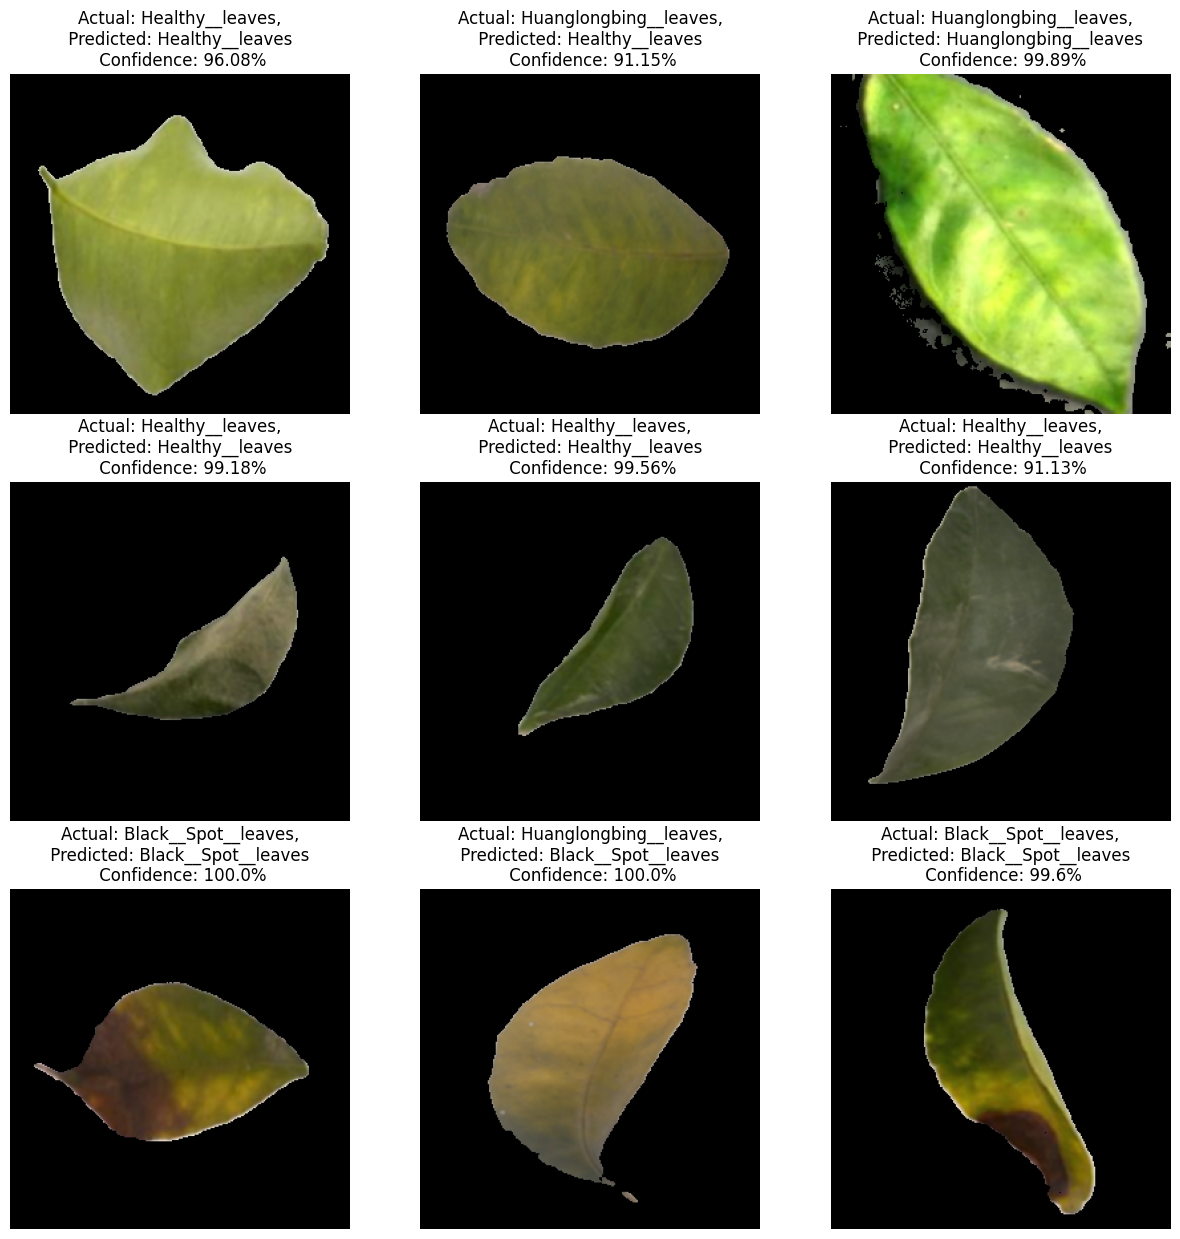

In [22]:
plt.figure(figsize=(15,15))

for images,labels in segl_test_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        predicted_class,confidence=predict(l_model,images[i])
        actual_class=leaf_class_name[labels[i].astype("int")]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")
    break

In [23]:
predictions=l_model.predict_generator(segl_test_generator,steps=len(segl_test_generator))
predicted_classes=np.array(np.argmax(predictions,axis=1))

C:\Users\Krishna\AppData\Local\Temp\ipykernel_1996\2599699225.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=l_model.predict_generator(segl_test_generator,steps=len(segl_test_generator))


In [25]:
labels = []
for batch in segl_test_generator:
    labels.append(batch[1])
labels = np.concatenate(labels)

In [26]:
cm=confusion_matrix(labels,predicted_classes)

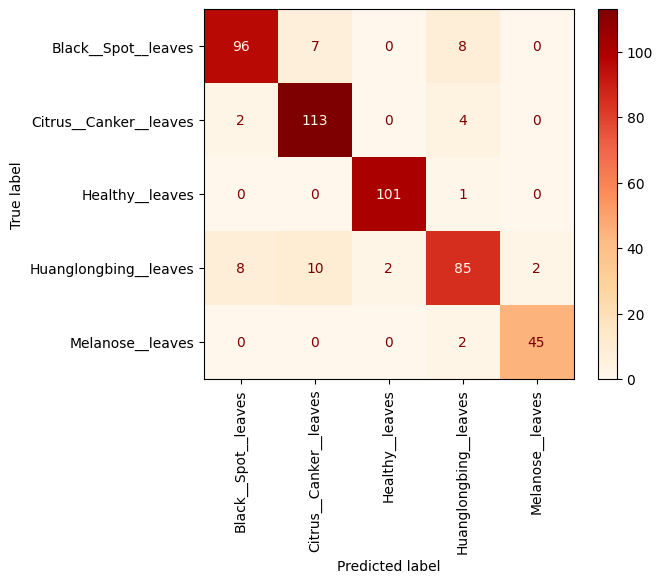

In [27]:
display_cm=ConfusionMatrixDisplay(cm,display_labels=leaf_class_name)
display_cm.plot(cmap='OrRd',xticks_rotation=90)
plt.show()

In [28]:
l_model.save("../Models/l_model.h5")

### Testing on Image

In [11]:
load_model=keras.models.load_model('../Models/l_model.h5')

img=cv2.imread('../Orange/datasets/test/Citrus__Canker__leaves/ccl (79).jpg')
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

obj1=preprocessing.IMAGE_PREPROCESSING(img_rgb)
gen=obj1.PreprocessImage(leaf_class_name)

image = (gen[0][0] * 255).round().astype(np.uint8)
obj2 = segmentation.IMAGE_SEGMENTATION(image)
mask = obj2.AnalyzeImage()
image = obj2.Segmentation(mask)

arr=[image]
array=np.array(arr)
pred=load_model.predict(array)
pred_class=leaf_class_name[np.argmax(pred)]
print(pred_class)

obj3=classification.CNN()
solution=obj3.Solution(pred_class)
print(solution)

1/1 [==============================] - 0s 129ms/step
Citrus__Canker__leaves



 a. If the disease is introduced in area, all infected trees should be removed and destroyed. 
 b. In areas where disease is endemic, windbreaks can help to reduce severity. 
 c. Cultural control of disease should focus on controlling leaf miner populations, utilizing wind breaks and application of copper spray.


### Wrongly identified images

In [33]:
import os

wrongly_classified_images = []

# Assuming the leaf and fruit disease images are stored in a folder
folder_path = "../Orange/datasets/test/"

# Assuming you have a trained CNN model
model = keras.models.load_model('../Models/l_model.h5')  # Your trained CNN model

# Define a list of leaf disease class names
leaf_disease_classes = leaf_class_name

# Iterate over the leaf disease class names
for class_name in leaf_disease_classes:
    class_folder_path = os.path.join(folder_path, class_name)

    # Skip if the leaf disease class folder doesn't exist
    if not os.path.isdir(class_folder_path):
        continue

    # Iterate over the files in the leaf disease class folder
    for filename in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, filename)

        img=cv2.imread(image_path)
        img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        obj1=preprocessing.IMAGE_PREPROCESSING(img_rgb)
        gen=obj1.PreprocessImage(leaf_class_name)
        # # Load and preprocess the image (this step may vary depending on your implementation)
        # image = load_image(image_path)
        # preprocessed_image = preprocess_image(image)
        image = (gen[0][0] * 255).round().astype(np.uint8)
        obj2 = segmentation.IMAGE_SEGMENTATION(image)
        mask = obj2.AnalyzeImage()
        image = obj2.Segmentation(mask)
        # # Make predictions using the CNN model
        # predictions = model.predict(preprocessed_image)
        arr=[image]
        array=np.array(arr)
        pred=model.predict(array)
        pred_class=leaf_class_name[np.argmax(pred)]
        # # Get the predicted class
        # predicted_class = np.argmax(predictions)
        true_label = leaf_class_name[leaf_disease_classes.index(class_name)]
        # Compare the predicted class with the true label
        if pred_class != true_label:
            wrongly_classified_images.append((filename, true_label, pred_class))


# Print the list of wrongly classified image paths
print("Wrongly classified images:")
for image_details in wrongly_classified_images:
    image_name, true_label, predicted_class = image_details
    print(f"Image: {image_name}, Actual Class: {true_label}, Predicted Class: {predicted_class}")


1/1 [==============================] - 0s 30ms/step
Wrongly classified images:
Image: bsl (122).png, Actual Class: Black__Spot__leaves, Predicted Class: Huanglongbing__leaves
Image: bsl (149).png, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (174).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (2).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (246).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Huanglongbing__leaves
Image: bsl (26).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (261).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (276).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Huanglongbing__leaves
Image: bsl (277).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Huanglongbing__leaves
Image: bsl (278).jpg, Actual Class: Black__Spot__leaves

## Working with both Fruit and Leaf Images

In [12]:
fl_class_name=["Black__Spot__fruits","Black__Spot__leaves","Citrus__Canker__fruits","Citrus__Canker__leaves","Citrus__Scab__fruits","Healthy__fruits","Healthy__leaves","Huanglongbing__fruits","Huanglongbing__leaves","Melanose__leaves"]

### Preprocess Image

In [5]:
path="../Orange/datasets/train/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
fl_train_generator=obj1.PreprocessImage(fl_class_name)
fl_train_generator

Found 4182 images belonging to 10 classes.


In [6]:
path="../Orange/datasets/val/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
fl_val_generator=obj1.PreprocessImage(fl_class_name)
fl_val_generator

Found 594 images belonging to 10 classes.


In [7]:
path="../Orange/datasets/test/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
fl_test_generator=obj1.PreprocessImage(fl_class_name)
fl_test_generator

Found 1218 images belonging to 10 classes.


### Segmentate Image

In [8]:
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, generator):
    self.generator = generator

  def __len__(self):
    return len(self.generator)

  def __getitem__(self, idx):
    x_batch, y_batch = self.generator[idx]
    x_augmented = []
    for i in range(len(x_batch)):
      image = (x_batch[i] * 255).round().astype(np.uint8)
      obj2 = segmentation.IMAGE_SEGMENTATION(image)
      mask = obj2.AnalyzeImage()
      image = obj2.Segmentation(mask)
      x_augmented.append(image)
    return np.array(x_augmented), np.array(y_batch)

In [9]:
segfl_train_generator = DataGenerator(fl_train_generator)
segfl_val_generator = DataGenerator(fl_val_generator)
segfl_test_generator = DataGenerator(fl_test_generator)

### Classification of Image

In [10]:
obj3=classification.CNN()
fl_model=obj3.Classification(input_shape=input_shape,n_classes=len(fl_class_name))

fl_model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [11]:
steps_per_epochs=len(segfl_train_generator)
validation_steps=len(segfl_val_generator)
print(steps_per_epochs,validation_steps)

131 19


In [12]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [13]:
history = fl_model.fit(segfl_train_generator, steps_per_epoch=steps_per_epochs, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1, validation_data=segfl_val_generator, validation_steps=validation_steps,
                      callbacks=[early_stop])

Epoch 1/30
131/131 [==============================] - 316s 2s/step - loss: 1.5324 - accuracy: 0.5172 - val_loss: 0.9358 - val_accuracy: 0.6178
Epoch 2/30
131/131 [==============================] - 318s 2s/step - loss: 0.7084 - accuracy: 0.7367 - val_loss: 0.6290 - val_accuracy: 0.7677
Epoch 3/30
131/131 [==============================] - 323s 2s/step - loss: 0.5659 - accuracy: 0.7941 - val_loss: 0.7482 - val_accuracy: 0.7340
Epoch 4/30
131/131 [==============================] - 320s 2s/step - loss: 0.4833 - accuracy: 0.8223 - val_loss: 0.4922 - val_accuracy: 0.8451
Epoch 5/30
131/131 [==============================] - 321s 2s/step - loss: 0.3664 - accuracy: 0.8792 - val_loss: 0.4274 - val_accuracy: 0.8603
Epoch 6/30
131/131 [==============================] - 324s 2s/step - loss: 0.3461 - accuracy: 0.8780 - val_loss: 0.4964 - val_accuracy: 0.8182
Epoch 7/30
131/131 [==============================] - 318s 2s/step - loss: 0.2649 - accuracy: 0.9130 - val_loss: 0.4266 - val_accuracy: 0.8519

In [14]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [15]:
EPOCHS=30

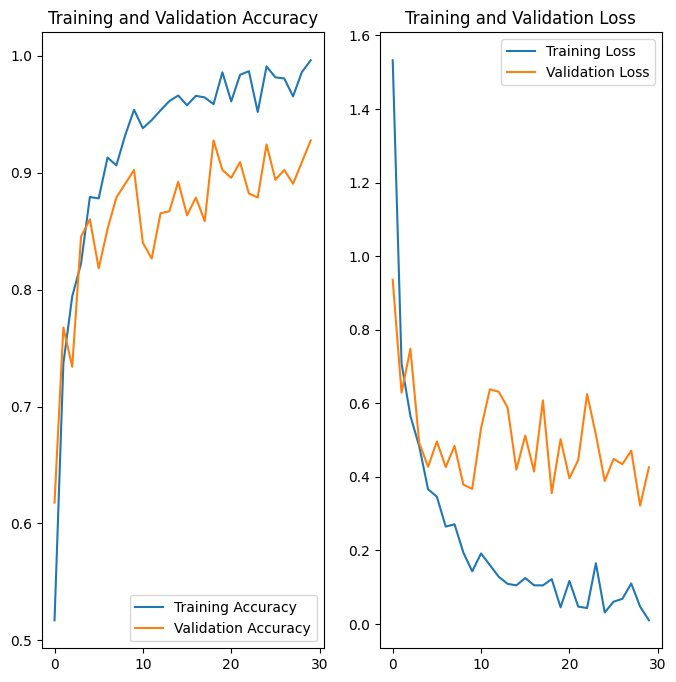

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
fl_pr=fl_model.evaluate(segfl_test_generator)

39/39 [==============================] - 49s 1s/step - loss: 0.4495 - accuracy: 0.9245


In [145]:
def predict(model,img):

    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0) #create a batch

    predictions=model.predict(img_array)

    predicted_class=fl_class_name[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 33ms/step


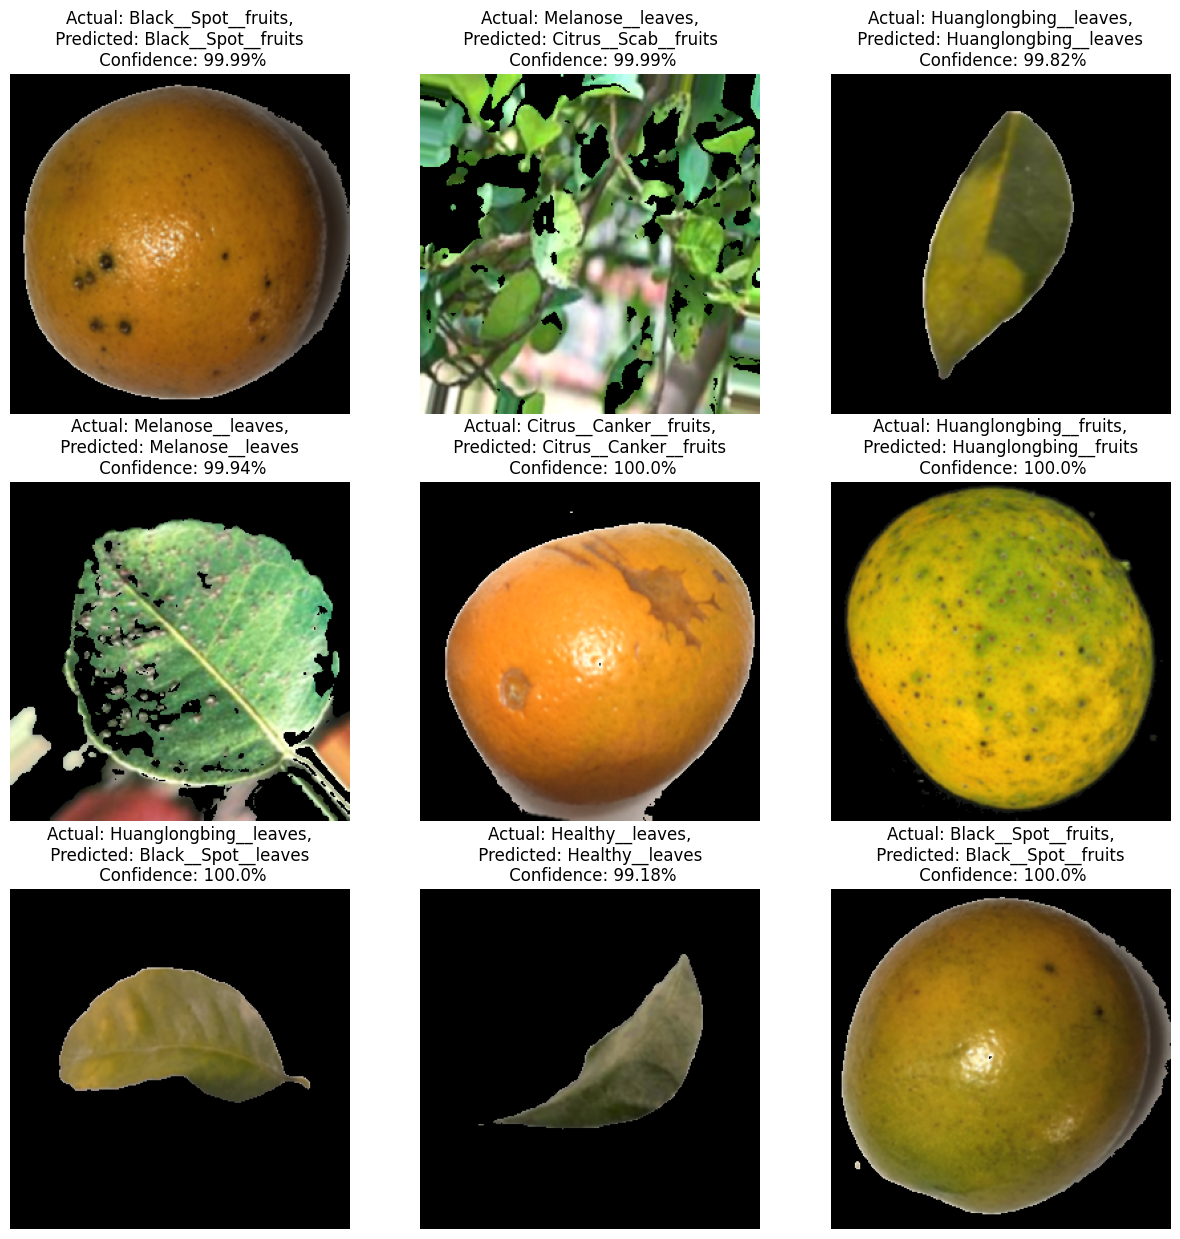

In [20]:
plt.figure(figsize=(15,15))

for images,labels in segfl_test_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        predicted_class,confidence=predict(fl_model,images[i])
        actual_class=fl_class_name[labels[i].astype("int")]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")
    break

In [29]:
predictions=fl_model.predict_generator(segfl_test_generator,steps=len(segfl_test_generator))
predicted_classes=np.array(np.argmax(predictions,axis=1))

C:\Users\Krishna\AppData\Local\Temp\ipykernel_5800\4207999946.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=fl_model.predict_generator(segfl_test_generator,steps=len(segfl_test_generator))


In [30]:
labels = []
for batch in segfl_test_generator:
    labels.append(batch[1])
labels = np.concatenate(labels)

In [31]:
cm=confusion_matrix(labels,predicted_classes)

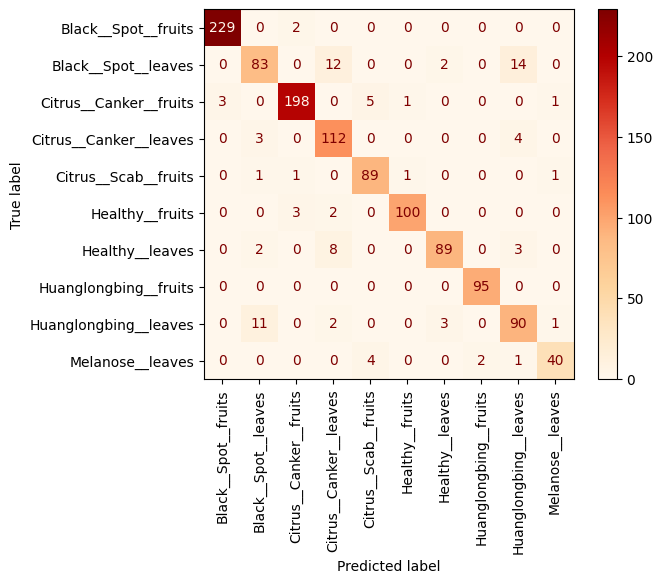

In [32]:
display_cm=ConfusionMatrixDisplay(cm,display_labels=fl_class_name)
display_cm.plot(cmap='OrRd',xticks_rotation=90)
plt.show()

In [26]:
fl_model.save("../Models/fl_model.h5")

### Testing on Image

In [13]:
load_model=keras.models.load_model('../Models/fl_model.h5')

img=cv2.imread('../Orange/datasets/test/Citrus__Canker__leaves/ccl (79).jpg')
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

obj1=preprocessing.IMAGE_PREPROCESSING(img_rgb)
gen=obj1.PreprocessImage(fl_class_name)

image = (gen[0][0] * 255).round().astype(np.uint8)
obj2 = segmentation.IMAGE_SEGMENTATION(image)
mask = obj2.AnalyzeImage()
image = obj2.Segmentation(mask)

arr=[image]
array=np.array(arr)
pred=load_model.predict(array)
pred_class=fl_class_name[np.argmax(pred)]
print(pred_class)

obj3=classification.CNN()
solution=obj3.Solution(pred_class)
print(solution)

1/1 [==============================] - 0s 112ms/step
Citrus__Canker__leaves



 a. If the disease is introduced in area, all infected trees should be removed and destroyed. 
 b. In areas where disease is endemic, windbreaks can help to reduce severity. 
 c. Cultural control of disease should focus on controlling leaf miner populations, utilizing wind breaks and application of copper spray.


### Wrongly identified images

In [34]:
import os

wrongly_classified_images = []

# Assuming the leaf and fruit disease images are stored in a folder
folder_path = "../Orange/datasets/test/"

# Assuming you have a trained CNN model
model = keras.models.load_model('../Models/fl_model.h5')  # Your trained CNN model

# Define a list of leaf disease class names
fl_disease_classes = fl_class_name

# Iterate over the leaf disease class names
for class_name in fl_disease_classes:
    class_folder_path = os.path.join(folder_path, class_name)

    # Skip if the leaf disease class folder doesn't exist
    if not os.path.isdir(class_folder_path):
        continue

    # Iterate over the files in the leaf disease class folder
    for filename in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, filename)

        img=cv2.imread(image_path)
        img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        obj1=preprocessing.IMAGE_PREPROCESSING(img_rgb)
        gen=obj1.PreprocessImage(fl_class_name)
        # # Load and preprocess the image (this step may vary depending on your implementation)
        # image = load_image(image_path)
        # preprocessed_image = preprocess_image(image)
        image = (gen[0][0] * 255).round().astype(np.uint8)
        obj2 = segmentation.IMAGE_SEGMENTATION(image)
        mask = obj2.AnalyzeImage()
        image = obj2.Segmentation(mask)
        # # Make predictions using the CNN model
        # predictions = model.predict(preprocessed_image)
        arr=[image]
        array=np.array(arr)
        pred=model.predict(array)
        pred_class=fl_class_name[np.argmax(pred)]
        # # Get the predicted class
        # predicted_class = np.argmax(predictions)
        true_label = fl_class_name[fl_disease_classes.index(class_name)]
        # Compare the predicted class with the true label
        if pred_class != true_label:
            wrongly_classified_images.append((filename, true_label, pred_class))


# Print the list of wrongly classified image paths
print("Wrongly classified images:")
for image_details in wrongly_classified_images:
    image_name, true_label, predicted_class = image_details
    print(f"Image: {image_name}, Actual Class: {true_label}, Predicted Class: {predicted_class}")


1/1 [==============================] - 0s 36ms/step
Wrongly classified images:
Image: bsf (613).jpg, Actual Class: Black__Spot__fruits, Predicted Class: Citrus__Canker__fruits
Image: bsl (107).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Huanglongbing__leaves
Image: bsl (11).png, Actual Class: Black__Spot__leaves, Predicted Class: Healthy__leaves
Image: bsl (110).png, Actual Class: Black__Spot__leaves, Predicted Class: Healthy__leaves
Image: bsl (122).png, Actual Class: Black__Spot__leaves, Predicted Class: Huanglongbing__leaves
Image: bsl (149).png, Actual Class: Black__Spot__leaves, Predicted Class: Huanglongbing__leaves
Image: bsl (174).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (2).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (226).jpg, Actual Class: Black__Spot__leaves, Predicted Class: Citrus__Canker__leaves
Image: bsl (24).jpg, Actual Class: Black__Spot__leaves, Predicted Cl

## Checking Performance on Test-Cases

In [156]:
model=keras.models.load_model('../Models/fl_model.h5')

Found 50 images belonging to 10 classes.
1/1 [==============================] - 0s 94ms/step


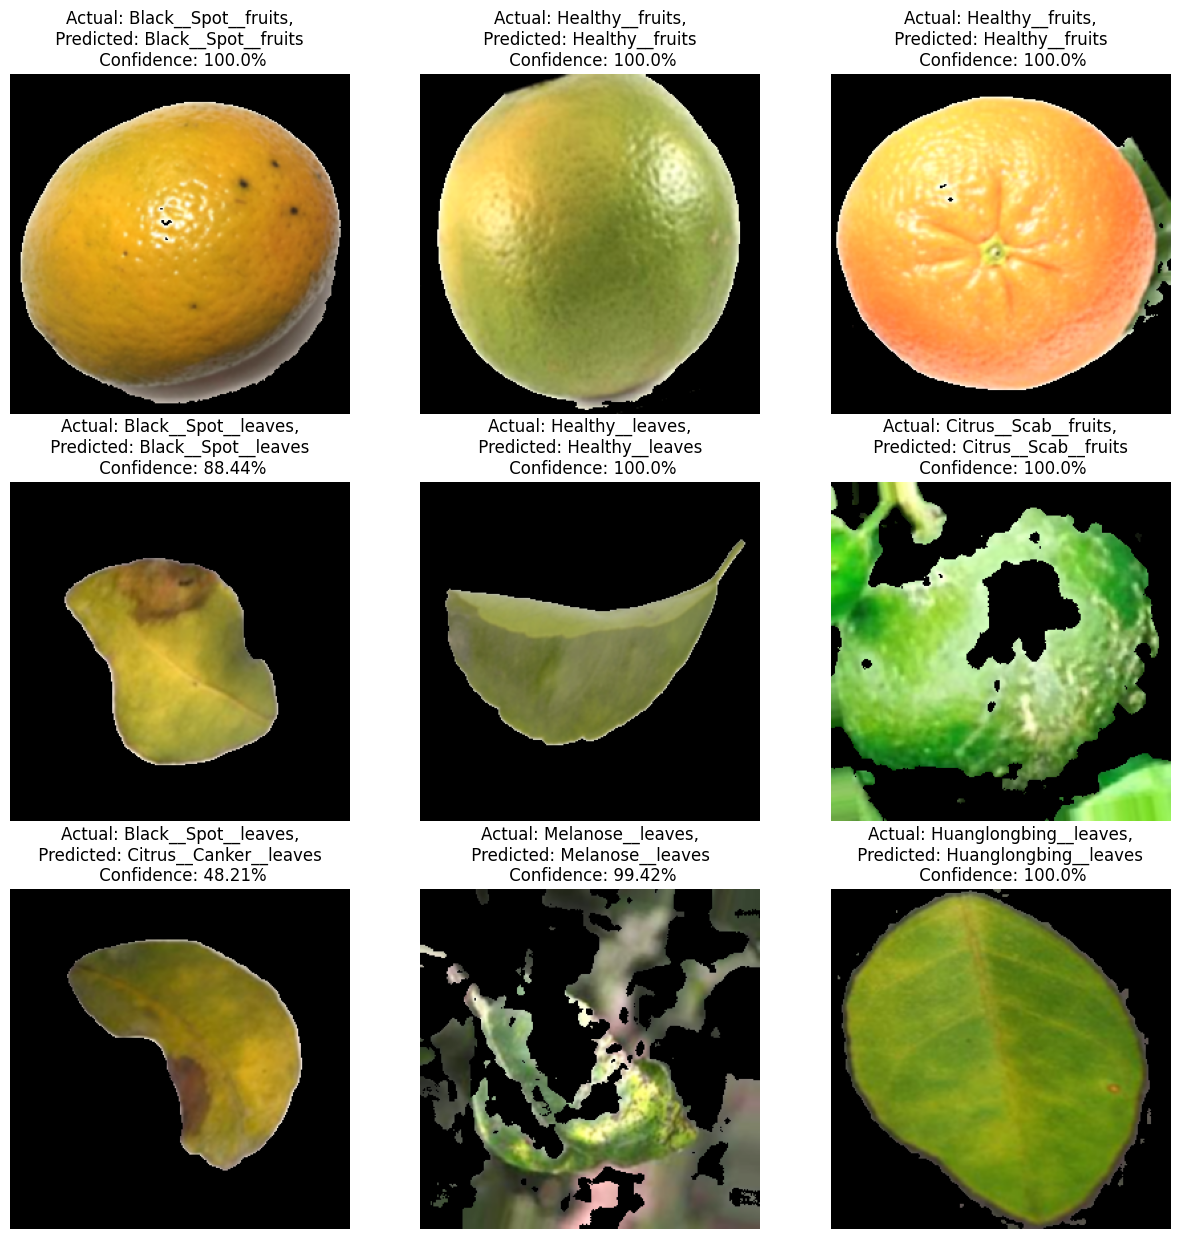

In [157]:
path="../Orange/testcase1/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
testcase1_generator=obj1.PreprocessImage(fl_class_name)
testcase1_generator

seg_tc1_generator = DataGenerator(testcase1_generator)

pr=model.evaluate(seg_tc1_generator)

plt.figure(figsize=(15,15))

for images,labels in seg_tc1_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        predicted_class,confidence=predict(model,images[i])
        actual_class=fl_class_name[labels[i].astype("int")]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")
    break

Found 50 images belonging to 10 classes.
1/1 [==============================] - 0s 103ms/step


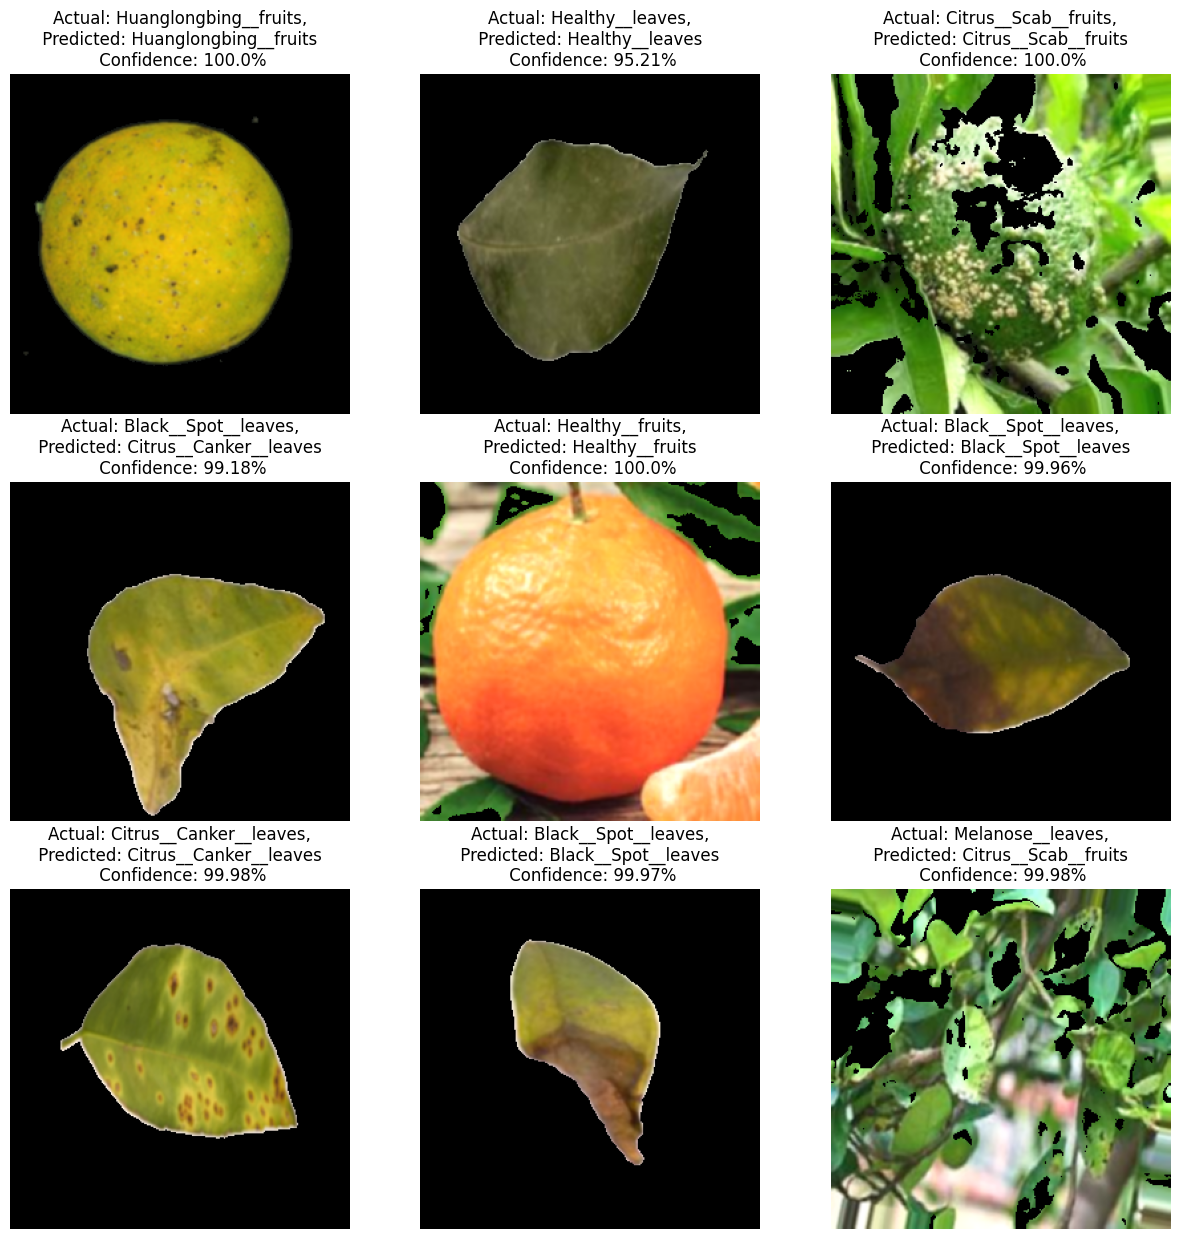

In [158]:
path="../Orange/testcase2/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
testcase2_generator=obj1.PreprocessImage(fl_class_name)
testcase2_generator

seg_tc2_generator = DataGenerator(testcase2_generator)

pr=model.evaluate(seg_tc2_generator)

plt.figure(figsize=(15,15))

for images,labels in seg_tc2_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        predicted_class,confidence=predict(model,images[i])
        actual_class=fl_class_name[labels[i].astype("int")]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")
    break

Found 50 images belonging to 10 classes.
1/1 [==============================] - 0s 93ms/step


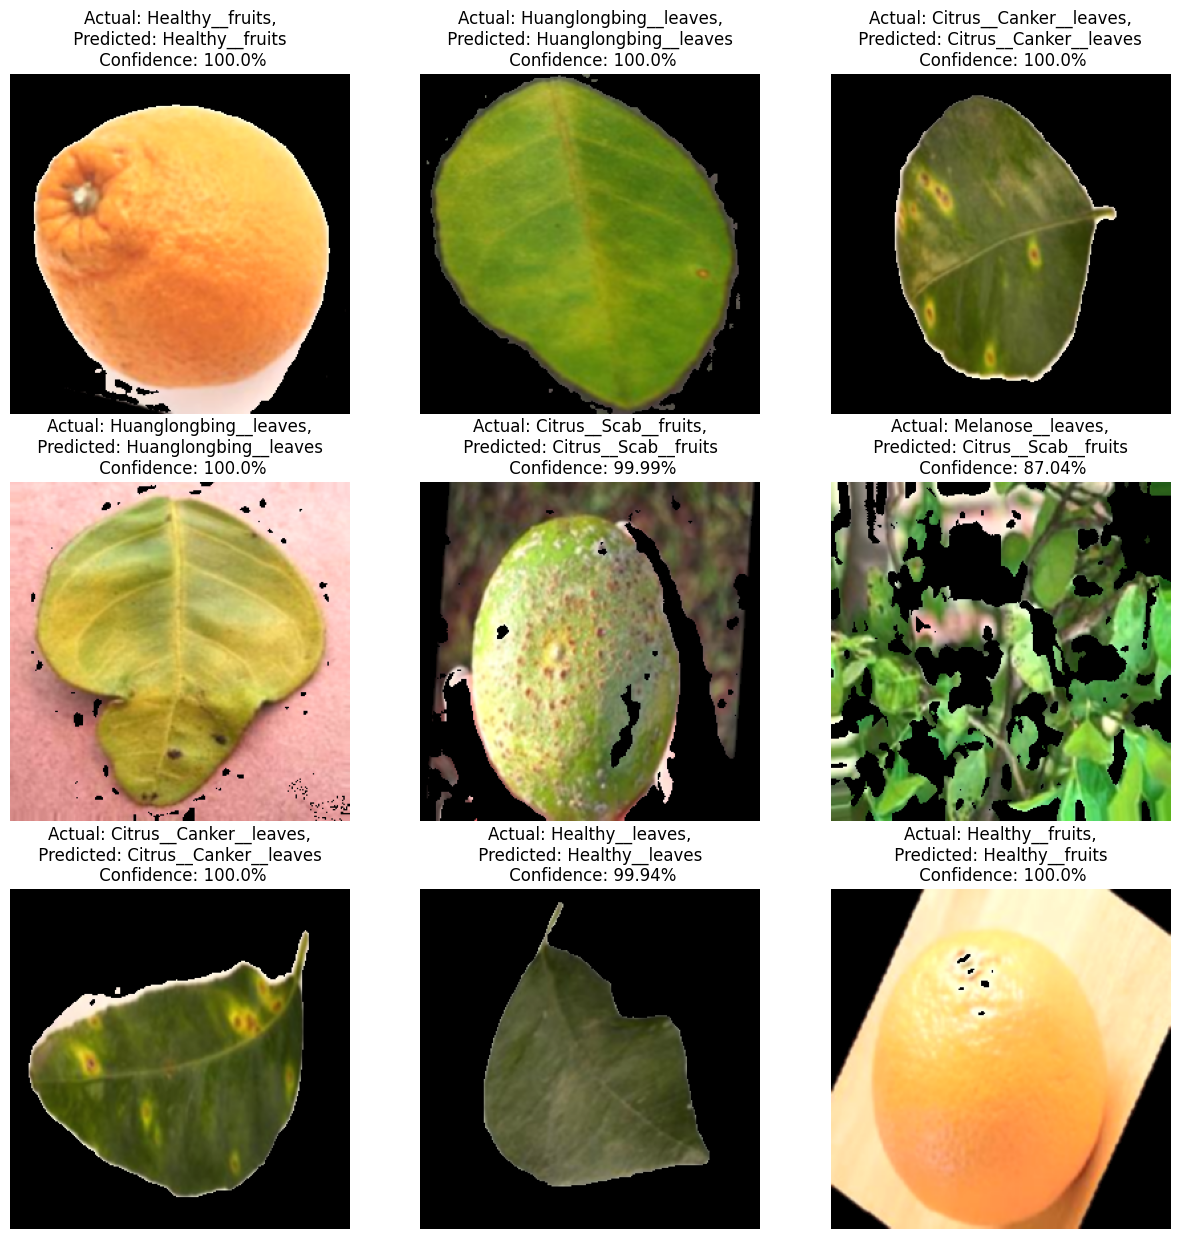

In [159]:
path="../Orange/testcase3/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
testcase3_generator=obj1.PreprocessImage(fl_class_name)
testcase3_generator

seg_tc3_generator = DataGenerator(testcase3_generator)

pr=model.evaluate(seg_tc3_generator)

plt.figure(figsize=(15,15))

for images,labels in seg_tc3_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        predicted_class,confidence=predict(model,images[i])
        actual_class=fl_class_name[labels[i].astype("int")]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")
    break

## New Model Creation with Max. Class or High Confidence

In [10]:
# Load and initialize the three separate models
model_fruit = keras.models.load_model('../Models/f_model.h5') # Your code to load the fruit disease prediction model
model_leaf = keras.models.load_model('../Models/l_model.h5') # Your code to load the leaf disease prediction model
model_combined = keras.models.load_model('../Models/fl_model.h5')  # Your code to load the combined fruit and leaf disease prediction model

# Define the classes for each model
classes_fruit = ["Black__Spot__fruits", "Citrus__Canker__fruits", "Citrus__Scab__fruits", "Healthy__fruits", "Huanglongbing__fruits"]
classes_leaf = ["Black__Spot__leaves", "Citrus__Canker__leaves", "Healthy__leaves", "Huanglongbing__leaves", "Melanose__leaves"]
classes_combined = ["Black__Spot__fruits", "Black__Spot__leaves", "Citrus__Canker__fruits", "Citrus__Canker__leaves", "Citrus__Scab__fruits",
                    "Healthy__fruits", "Healthy__leaves", "Huanglongbing__fruits", "Huanglongbing__leaves", "Melanose__leaves"]

def predict_ensemble(sample):
    # Predict with the first model (fruit disease)
    prediction_fruit = model_fruit.predict(sample)

    # Predict with the second model (leaf disease)
    prediction_leaf = model_leaf.predict(sample)

    # Predict with the third model (combined fruit and leaf disease)
    prediction_combined = model_combined.predict(sample)

    # Find the maximum predicted class and confidence from each model
    max_class_fruit = classes_fruit[np.argmax(prediction_fruit)]
    max_class_leaf = classes_leaf[np.argmax(prediction_leaf)]
    max_class_combined = classes_combined[np.argmax(prediction_combined)]

    # Check if all models have the same disease class
    if max_class_fruit == max_class_leaf == max_class_combined:
        final_prediction_class = max_class_fruit
    elif max_class_fruit == max_class_leaf:
        final_prediction_class = max_class_fruit
    elif max_class_fruit == max_class_combined:
        final_prediction_class = max_class_fruit
    elif max_class_leaf == max_class_combined:
        final_prediction_class = max_class_leaf
    else:
        # All three models have different disease class names
        # Select the class with the highest confidence
        max_confidence_fruit = np.max(prediction_fruit)
        max_confidence_leaf = np.max(prediction_leaf)
        max_confidence_combined = np.max(prediction_combined)

        if max_confidence_fruit >= max_confidence_leaf and max_confidence_fruit >= max_confidence_combined:
            final_prediction_class = max_class_fruit
        elif max_confidence_leaf >= max_confidence_fruit and max_confidence_leaf >= max_confidence_combined:
            final_prediction_class = max_class_leaf
        else:
            final_prediction_class = max_class_combined

    # Return the final prediction
    return classes_combined.index(final_prediction_class)


# Usage:
img = cv2.imread('../Orange/datasets/test/Citrus__Canker__leaves/ccl (423).jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
obj1 = preprocessing.IMAGE_PREPROCESSING(img_rgb)
gen = obj1.PreprocessImage(fl_class_name)
image = (gen[0][0] * 255).round().astype(np.uint8)

# Perform segmentation
obj2 = segmentation.IMAGE_SEGMENTATION(image)
mask = obj2.AnalyzeImage()
image = obj2.Segmentation(mask)

arr = [image]
array = np.array(arr)

sample = array  # Your code to load an input sample
prediction = predict_ensemble(sample)
print("Ensemble Prediction:", prediction)

1/1 [==============================] - 0s 126ms/step
Ensemble Prediction: 3


In [36]:
path="../Orange/datasets/test/"
obj1=preprocessing.IMAGE_PREPROCESSING(path)
combine_test_generator=obj1.PreprocessImage(fl_class_name)
combine_test_generator

Found 1218 images belonging to 10 classes.


In [37]:
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, generator):
    self.generator = generator

  def __len__(self):
    return len(self.generator)

  def __getitem__(self, idx):
    x_batch, y_batch = self.generator[idx]
    x_augmented = []
    for i in range(len(x_batch)):
      image = (x_batch[i] * 255).round().astype(np.uint8)
      obj2 = segmentation.IMAGE_SEGMENTATION(image)
      mask = obj2.AnalyzeImage()
      image = obj2.Segmentation(mask)
      x_augmented.append(image)
    return np.array(x_augmented), np.array(y_batch)

In [38]:
segcomb_test_generator = DataGenerator(combine_test_generator)

In [204]:
pred_labels = []
true_labels = []

for (images, labels), _ in zip(segcomb_test_generator, range(len(segcomb_test_generator))):
    batch_predictions = []

    for img in images:
        arr = [img]
        array = np.array(arr)

        prediction=predict_ensemble(array)

        batch_predictions.append(prediction)

    pred_labels.extend(batch_predictions)
    true_labels.append(labels)

integer_list = [[int(x) for x in arr] for arr in true_labels]
true_labels = [element for sublist in integer_list for element in sublist]
print(pred_labels)
print(true_labels)

1/1 [==============================] - 0s 170ms/step
[4, 0, 7, 0, 2, 5, 2, 3, 7, 4, 0, 0, 2, 6, 3, 0, 2, 0, 3, 2, 1, 6, 8, 7, 4, 2, 3, 8, 1, 0, 1, 6, 7, 2, 5, 5, 1, 7, 0, 9, 0, 2, 3, 6, 2, 0, 8, 3, 7, 1, 2, 2, 1, 5, 6, 5, 3, 2, 2, 2, 4, 8, 0, 5, 5, 4, 0, 7, 1, 0, 8, 3, 7, 5, 5, 3, 1, 1, 6, 8, 4, 3, 4, 6, 0, 0, 0, 1, 4, 3, 2, 6, 0, 2, 7, 5, 7, 7, 1, 0, 2, 1, 0, 0, 2, 0, 4, 4, 5, 3, 2, 3, 0, 5, 6, 0, 1, 8, 4, 0, 0, 4, 5, 5, 6, 2, 3, 7, 0, 2, 4, 2, 0, 0, 8, 0, 6, 1, 4, 8, 2, 8, 6, 0, 2, 5, 1, 2, 0, 7, 8, 4, 2, 5, 0, 4, 1, 0, 5, 4, 0, 2, 2, 3, 7, 5, 0, 0, 0, 0, 0, 5, 1, 5, 3, 8, 6, 8, 2, 0, 4, 9, 3, 2, 0, 5, 2, 3, 4, 3, 0, 0, 7, 2, 3, 3, 0, 3, 8, 6, 7, 8, 3, 5, 0, 3, 6, 0, 2, 1, 0, 5, 6, 2, 0, 6, 0, 1, 8, 8, 7, 9, 8, 0, 3, 5, 4, 6, 1, 5, 2, 0, 3, 0, 4, 0, 0, 0, 5, 3, 0, 2, 0, 0, 3, 2, 3, 2, 7, 7, 0, 2, 9, 4, 3, 3, 2, 0, 1, 2, 5, 5, 8, 2, 9, 1, 4, 8, 9, 0, 2, 2, 0, 2, 8, 7, 0, 0, 9, 0, 9, 2, 2, 7, 4, 4, 0, 3, 4, 2, 1, 3, 2, 0, 8, 2, 8, 0, 0, 0, 5, 2, 1, 3, 4, 8, 8, 0, 3, 4, 5, 5, 4, 4, 2, 4

In [205]:
print(len(pred_labels),len(true_labels))

1218 1218


In [206]:
cm=confusion_matrix(true_labels,pred_labels)

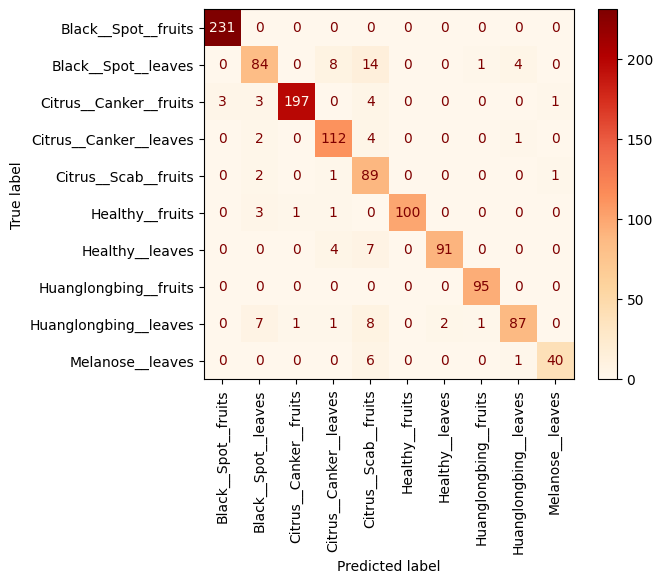

In [207]:
display_cm=ConfusionMatrixDisplay(cm,display_labels=fl_class_name)
display_cm.plot(cmap='OrRd',xticks_rotation=90)
plt.show()

In [208]:
acc=0

for i in range(len(true_labels)):
    if(true_labels[i] == pred_labels[i]):
        acc=acc+1

acc=acc/len(true_labels)
print(acc)

0.9244663382594417


## New Model Creation with Ensemble Learning

In [35]:
model1 = keras.models.load_model('../Models/f_model.h5')  # Model for fruit disease class
model2 = keras.models.load_model('../Models/l_model.h5')  # Model for leaf disease class
model3 = keras.models.load_model('../Models/fl_model.h5')  # Model for both fruit and leaf disease classes

# Define the class label mapping for each model
class_mapping_model1 = {0: 'Black__Spot__fruits', 1: 'Citrus__Canker__fruits', 2: 'Citrus__Scab__fruits', 3: 'Healthy__fruits', 4: 'Huanglongbing__fruits'}
class_mapping_model2 = {0: 'Black__Spot__leaves', 1: 'Citrus__Canker__leaves', 2: 'Healthy__leaves', 3: 'Huanglongbing__leaves', 4: 'Melanose__leaves'}
class_mapping_model3 = {0: 'Black__Spot__fruits', 1: 'Black__Spot__leaves', 2: 'Citrus__Canker__fruits', 3: 'Citrus__Canker__leaves', 4: 'Citrus__Scab__fruits', 5: 'Healthy__fruits', 6: 'Healthy__leaves', 7: 'Huanglongbing__fruits', 8: 'Huanglongbing__leaves', 9: 'Melanose__leaves'}

label_to_id = {
    'Black__Spot__fruits': 0,
    'Black__Spot__leaves': 1,
    'Citrus__Canker__fruits': 2,
    'Citrus__Canker__leaves': 3,
    'Citrus__Scab__fruits': 4,
    'Healthy__fruits': 5,
    'Healthy__leaves': 6,
    'Huanglongbing__fruits': 7,
    'Huanglongbing__leaves': 8,
    'Melanose__leaves': 9
}

def ensemble_predict(image):

    # Obtain predictions from each model
    pred1 = model1.predict(image)
    pred2 = model2.predict(image)
    pred3 = model3.predict(image)

    # Map the class labels to unique integer IDs
    mapped_pred1 = [label_to_id[class_mapping_model1[i]] for i in np.argmax(pred1, axis=1)]
    mapped_pred2 = [label_to_id[class_mapping_model2[i]] for i in np.argmax(pred2, axis=1)]
    mapped_pred3 = [label_to_id[class_mapping_model3[i]] for i in np.argmax(pred3, axis=1)]

    # Combine predictions using average probability
    combined_pred = np.concatenate([mapped_pred1, mapped_pred2, mapped_pred3])

    final_pred_id = np.argmax(np.bincount(combined_pred))
    final_pred = list(label_to_id.keys())[list(label_to_id.values()).index(final_pred_id)]

    return label_to_id[final_pred]

# Iterate through the dataset and make predictions using the ensemble model
img = cv2.imread('../Orange/datasets/test/Citrus__Canker__leaves/ccl (199).jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
obj1 = preprocessing.IMAGE_PREPROCESSING(img_rgb)
gen = obj1.PreprocessImage(fl_class_name)
image = (gen[0][0] * 255).round().astype(np.uint8)

# Perform segmentation
obj2 = segmentation.IMAGE_SEGMENTATION(image)
mask = obj2.AnalyzeImage()
image = obj2.Segmentation(mask)

arr = [image]
array = np.array(arr)

sample = array  # Your code to load an input sample
prediction = ensemble_predict(sample)
print("Ensemble Prediction:", prediction)


1/1 [==============================] - 0s 157ms/step
Ensemble Prediction: 3


In [39]:
pred_labels = []
true_labels = []

for (images, labels), _ in zip(segcomb_test_generator, range(len(segcomb_test_generator))):
    batch_predictions = []

    for img in images:
        arr = [img]
        array = np.array(arr)

        prediction=ensemble_predict(array)

        batch_predictions.append(prediction)

    pred_labels.extend(batch_predictions)
    true_labels.append(labels)

integer_list = [[int(x) for x in arr] for arr in true_labels]
true_labels = [element for sublist in integer_list for element in sublist]
print(pred_labels)
print(true_labels)

1/1 [==============================] - 0s 39ms/step
[3, 8, 9, 1, 0, 8, 2, 7, 2, 2, 4, 0, 5, 2, 5, 8, 0, 4, 0, 0, 5, 3, 7, 3, 8, 2, 3, 9, 6, 4, 2, 9, 7, 3, 9, 4, 7, 0, 6, 2, 2, 3, 2, 5, 4, 0, 0, 3, 8, 8, 6, 6, 5, 0, 2, 1, 5, 0, 4, 2, 4, 0, 0, 4, 4, 7, 1, 2, 4, 7, 5, 1, 5, 3, 8, 8, 0, 2, 0, 8, 0, 5, 2, 3, 0, 8, 5, 2, 5, 3, 2, 3, 6, 0, 5, 1, 7, 8, 0, 5, 0, 0, 2, 7, 1, 2, 2, 0, 6, 0, 0, 7, 1, 3, 2, 1, 8, 6, 8, 3, 8, 1, 0, 7, 8, 2, 8, 2, 4, 2, 0, 3, 3, 0, 7, 1, 3, 5, 4, 5, 6, 2, 2, 2, 3, 1, 6, 8, 5, 0, 0, 0, 1, 7, 5, 3, 6, 0, 6, 4, 8, 8, 1, 1, 2, 8, 2, 3, 3, 1, 4, 8, 5, 2, 8, 1, 7, 2, 4, 4, 9, 5, 1, 0, 5, 7, 2, 1, 3, 2, 1, 9, 4, 2, 1, 7, 1, 5, 2, 0, 2, 0, 3, 4, 0, 4, 5, 4, 0, 2, 2, 4, 2, 5, 3, 1, 0, 4, 9, 2, 3, 0, 9, 0, 2, 4, 3, 4, 9, 7, 6, 7, 4, 3, 0, 1, 3, 2, 3, 6, 3, 0, 9, 6, 6, 2, 6, 9, 6, 5, 1, 2, 3, 3, 1, 2, 7, 4, 7, 1, 1, 1, 0, 9, 7, 2, 3, 2, 2, 0, 2, 5, 0, 0, 0, 5, 8, 8, 2, 0, 1, 6, 0, 2, 0, 1, 2, 7, 0, 3, 0, 0, 0, 2, 7, 2, 1, 1, 8, 3, 0, 8, 2, 3, 3, 6, 0, 0, 6, 8, 6, 7, 2, 6, 0, 1,

In [40]:
cm=confusion_matrix(true_labels,pred_labels)

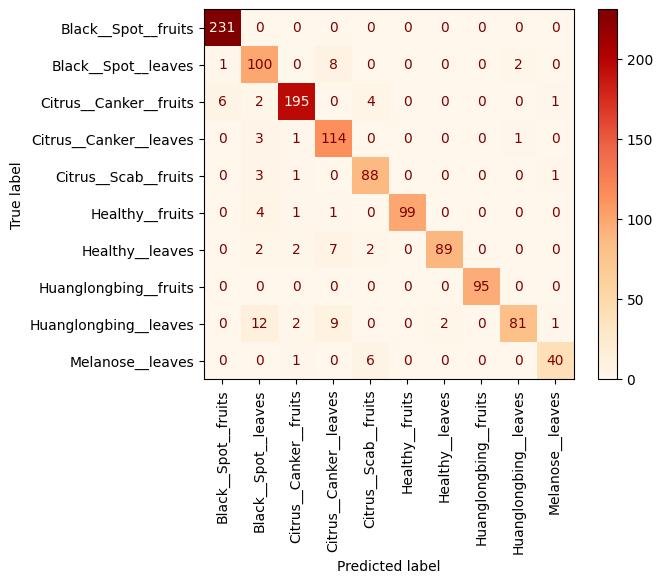

In [41]:
display_cm=ConfusionMatrixDisplay(cm,display_labels=fl_class_name)
display_cm.plot(cmap='OrRd',xticks_rotation=90)
plt.show()

In [42]:
acc=0

for i in range(len(true_labels)):
    if(true_labels[i] == pred_labels[i]):
        acc=acc+1

acc=acc/len(true_labels)
print(acc)

0.9293924466338259
